In [1]:
from __future__ import print_function, division

plot_to_pdf = False

if plot_to_pdf:
    import matplotlib as mpl
    mpl.use('pdf')
    
    import matplotlib.pyplot as plt
    
    plt.rc('font', family='serif', serif='Times')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=8) # 10
    plt.rc('ytick', labelsize=8) # 10
    plt.rc('axes', labelsize=8) # 10
    plt.rc('legend', fontsize=8) # 10
    title_font_size = 8
    data_font_size = 8
else:
    import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from time import time

from copy import deepcopy

%matplotlib inline

In [2]:
data = np.load('cartpole_policies_analytic_from_random_50.npz')
control_trajectories = data['control_trajectories']
state_trajectories = data['state_trajectories'][:,:,:]

print(control_trajectories.shape, state_trajectories.shape)

(415, 49, 1) (415, 4, 50)


In [3]:
# Use only every x-th trajectory
subsampling_step_one = 1
control_trajectories = control_trajectories[::subsampling_step_one,:,:]
state_trajectories = state_trajectories[::subsampling_step_one,:,:]
print(control_trajectories.shape, state_trajectories.shape)

sample_dim = state_trajectories.shape[0]
state_dim = state_trajectories.shape[1]
time_dim = state_trajectories.shape[2]

(415, 49, 1) (415, 4, 50)


## Explore all samples across a timestep

This is to verify that all samples have converged to the final target state

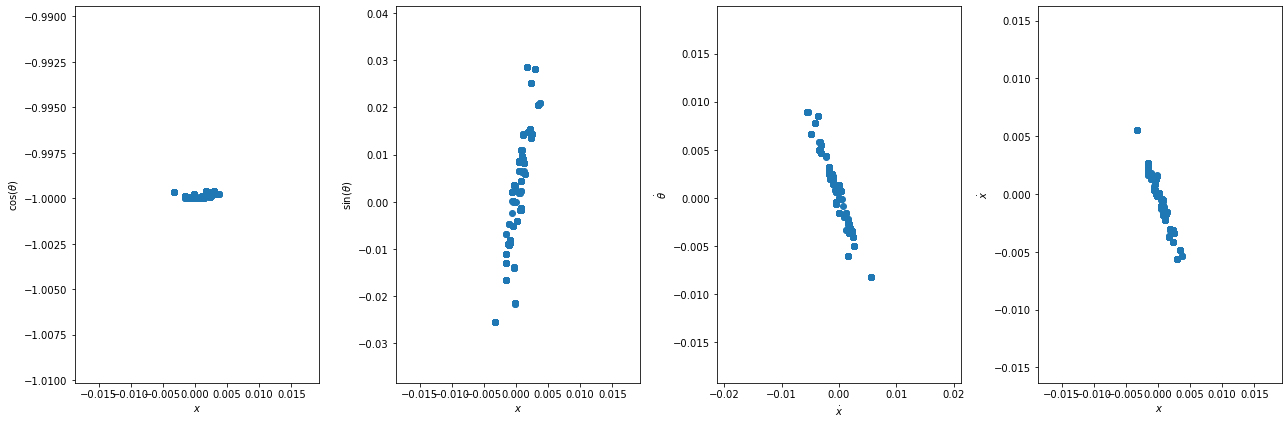

In [4]:
selected_timestep_to_explore = -1
fig = plt.figure()
fig.set_size_inches(18,6)
fig.add_subplot(1,4,1)
plt.scatter(state_trajectories[:,0,selected_timestep_to_explore], np.cos(state_trajectories[:,1,selected_timestep_to_explore]))
plt.xlabel(r'$x$')
plt.ylabel(r'$\cos(\theta)$')

fig.add_subplot(1,4,2)
plt.scatter(state_trajectories[:,0,selected_timestep_to_explore], np.sin(state_trajectories[:,1,selected_timestep_to_explore]))
plt.xlabel(r'$x$')
plt.ylabel(r'$\sin(\theta)$')

fig.add_subplot(1,4,3)
plt.scatter(state_trajectories[:,2,selected_timestep_to_explore], state_trajectories[:,3,selected_timestep_to_explore])
plt.xlabel(r'$\dot{x}$')
plt.ylabel(r'$\dot{\theta}$')
    
fig.add_subplot(1,4,4)
plt.scatter(state_trajectories[:,0,selected_timestep_to_explore], state_trajectories[:,2,selected_timestep_to_explore])
plt.xlabel(r'$x$')
plt.ylabel(r'$\dot{x}$')

plt.tight_layout()
plt.show()

## Preprocess dataset to stack into state-space vector

In [5]:
# # ORIGINAL: in 4D state space. New: 5D state space on manifold...
# dataset = np.zeros((sample_dim * time_dim, state_dim),dtype=np.double)
# print(dataset.shape)
# for i in range(sample_dim):
#     dataset[i * time_dim:(i+1) * time_dim,:] = state_trajectories[i,:,:].T

dataset = np.zeros((sample_dim * time_dim, state_dim + 1),dtype=np.double)
print(dataset.shape)
for i in range(sample_dim):
    dataset[i * time_dim:(i+1) * time_dim,0] = state_trajectories[i,0,:].T
    dataset[i * time_dim:(i+1) * time_dim,1] = np.cos(state_trajectories[i,1,:]).T
    dataset[i * time_dim:(i+1) * time_dim,2] = np.sin(state_trajectories[i,1,:]).T
    dataset[i * time_dim:(i+1) * time_dim,3] = state_trajectories[i,2,:].T
    dataset[i * time_dim:(i+1) * time_dim,4] = state_trajectories[i,3,:].T

(20750, 5)


## Plot all samples on cylinder

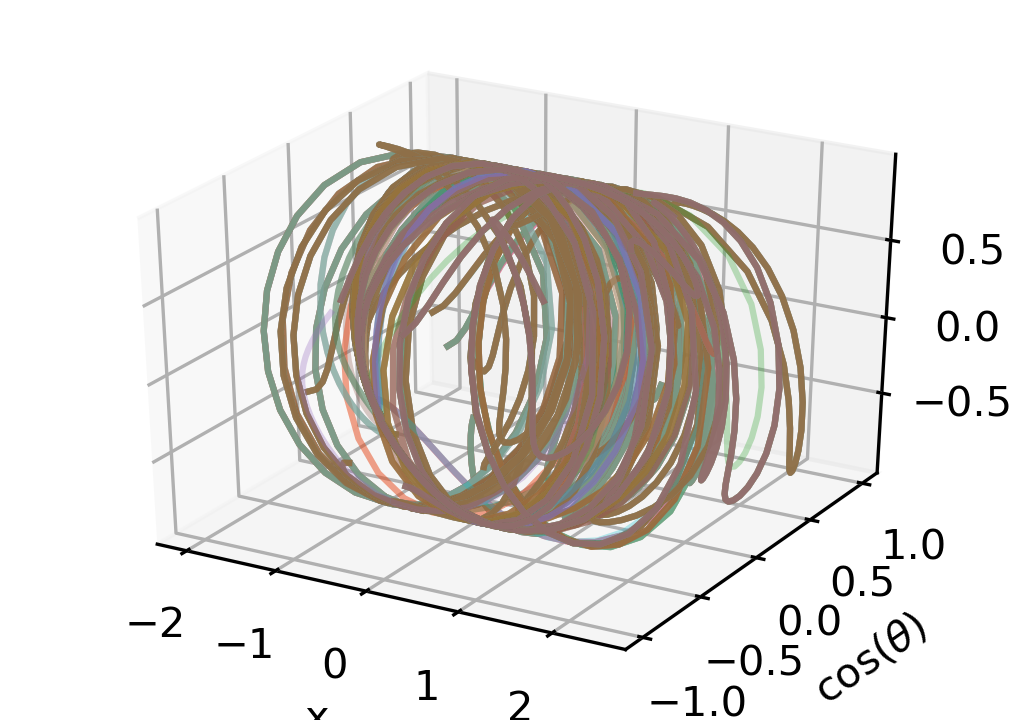

In [6]:
X_plot = dataset
fig = plt.figure()
fig.set_size_inches(3.5, 2.5)
fig.set_dpi(300)
ax = fig.add_subplot(111, projection='3d')
plot_x = X_plot[:,0].reshape(sample_dim,time_dim)
r = 1. #X_plot[:,3].reshape(sample_dim,time_dim) + 2.
plot_y = r * X_plot[:,1].reshape(sample_dim,time_dim)
plot_z = r * X_plot[:,2].reshape(sample_dim,time_dim)

for s in range(sample_dim):
    ax.plot(plot_x[s,:], plot_y[s,:], plot_z[s,:], alpha=0.3)

plt.xlabel('x')
plt.ylabel(r'$\cos(\theta)$')
plt.tight_layout()
plt.show()
# plt.zlabel('$\sin(\theta)$')

# Run persistent homology (Line-Segment Distance)


In [7]:
from topological_memory_clustering import *

In [8]:
demos = state_trajectories.swapaxes(1,2)

# Subsample
demos = demos[::2,::5,:]
print(demos.shape)

result, D = homology.compute_homology_filtration(demos, debug=True)

(208, 10, 4)
Distance computation time: 0.2382035255432129
Trajectory distance modification time: 0.0004115104675292969
[Dense] Elapsed Time: 293 seconds, 1637069 Edges added


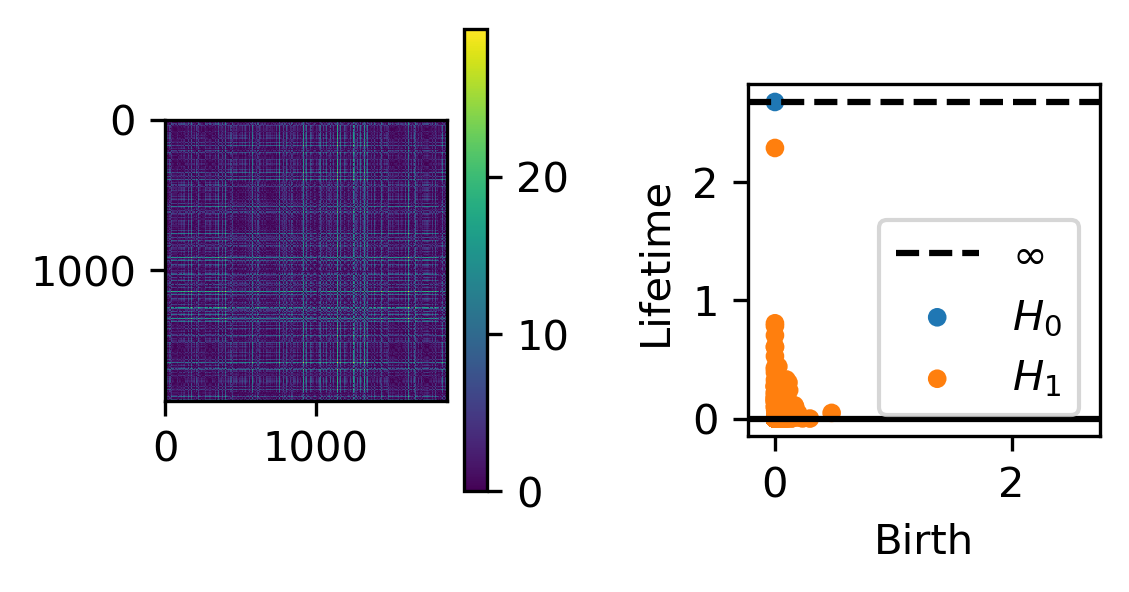

In [9]:
fig = plt.figure()
fig.set_size_inches(3.5,1.75)
fig.set_dpi(300)
plt.subplot(121)
plt.imshow(D)
plt.colorbar()
plt.subplot(122)
plot.plot_diagrams(result['dgms'], lifetime=True)
plt.tight_layout()
fig.subplots_adjust(left=0.1, bottom=0.11, right=.99, top=0.99) # for 3.5 x 1.75
plot_to_pdf and fig.savefig('plot/cartpole_filtration_results.pdf')
plt.show()

Potential number of holes: 1188
#classes 	 ratio 	 prev. 	 current 	 0.5*prev
       2	0.3521	2.2871	0.8054	1.8297
2


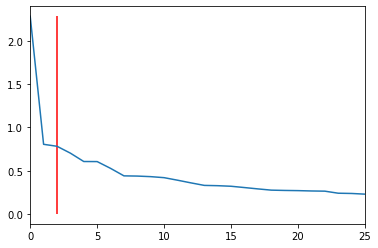

In [10]:
num_classes, _ = homology.get_num_classes_from_h1(result['dgms'][1], ratio_between_subsequent_persistence_pairs=0.8, debug=True)
print(num_classes)

In [11]:
demos_full = state_trajectories.swapaxes(1,2)
s = time()
D_pairwise = homology.get_pairwise_trajectory_distance_matrix_simple(demos_full)
e = time()
print("Pairwise distance matrix took {:.2f}s".format(e-s))

Pairwise distance matrix took 47.79s


In [12]:
labels = get_cluster_labels_from_pairwise_trajectory_distance_matrix(num_classes, D_pairwise, debug=True)
colors = clustering.get_colors_from_labels(labels)

Agglomerative clustering took 0.003318309783935547


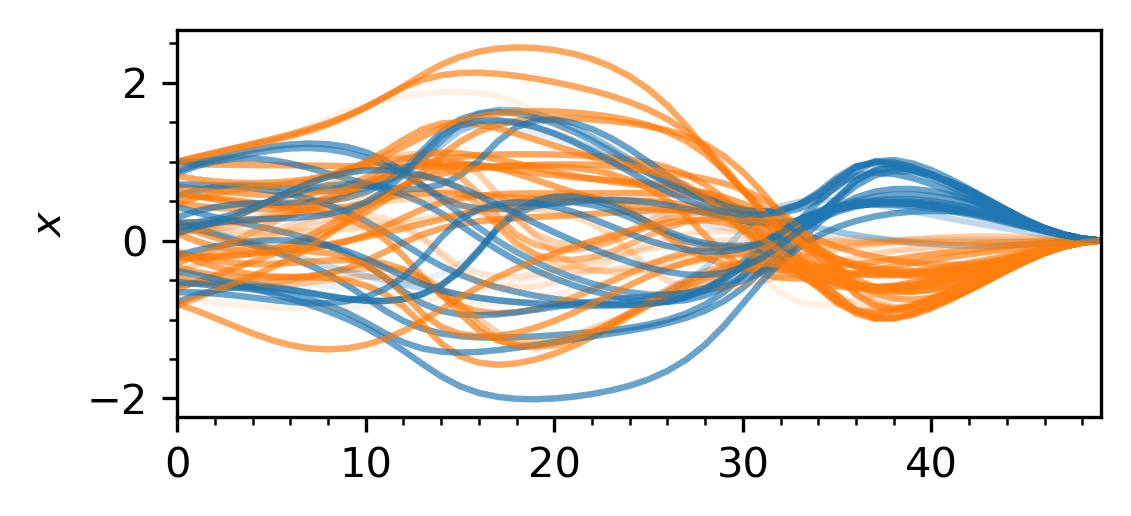

In [13]:
fig = plt.figure()
# fig.set_size_inches(6,3)
fig.set_size_inches(3.5,1.5)
fig.set_dpi(300)
plt.ylabel(r'$x$')
for i in range(demos_full.shape[0]):
    plt.plot(demos_full[i,:,0], alpha=0.1, color=colors[i])
plt.xlim(0, demos_full.shape[1]-1)
plt.minorticks_on()
plt.tight_layout()
fig.subplots_adjust(left=0.11, bottom=0.13, right=.99, top=0.99) # for 3.5 x 1.5
plot_to_pdf and fig.savefig('plot/cartpole_state_x_labelled.pdf')
plt.show()

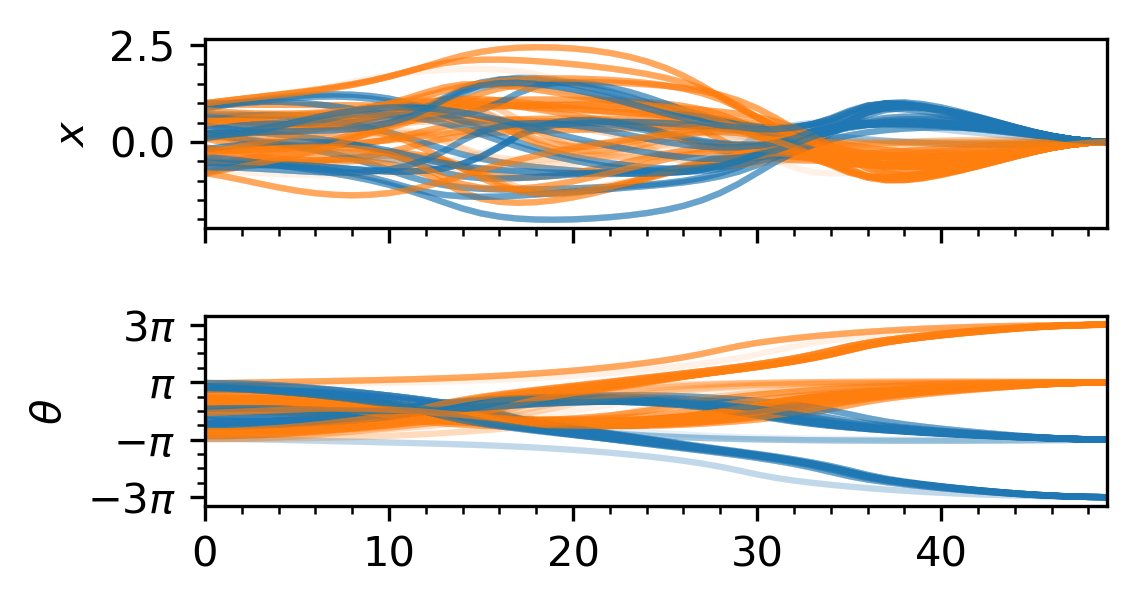

False

In [14]:
fig, ax = plt.subplots(2,1, sharex=True)
fig.set_dpi(300)
fig.set_size_inches(3.5,1.75)

ax[0].set_ylabel(r'$x$')
for i in range(demos_full.shape[0]):
    ax[0].plot(demos_full[i,:,0], alpha=0.1, color=colors[i], label='x')
ax[0].set_xlim(0, demos_full.shape[1]-1)
ax[0].minorticks_on()

ax[1].set_ylabel(r'$\theta$')
for i in range(demos_full.shape[0]):
    ax[1].plot(demos_full[i,:,1], alpha=0.1, color=colors[i], label=r'\theta')
ax[1].set_xlim(0, demos_full.shape[1]-1)
ax[1].minorticks_on()
ax[1].set_yticks([-3*np.pi,-np.pi,np.pi,3*np.pi], minor=False)
ax[1].set_yticklabels([r'$-3\pi$',r'$-\pi$',r'$\pi$',r'$3\pi$'], minor=False)

plt.tight_layout()

fig.subplots_adjust(left=0.131, bottom=0.1, right=.99, top=0.99) # for 3.5 x 1.5

plt.show()

plot_to_pdf and fig.savefig('plot/cartpole_state_labelled.pdf')

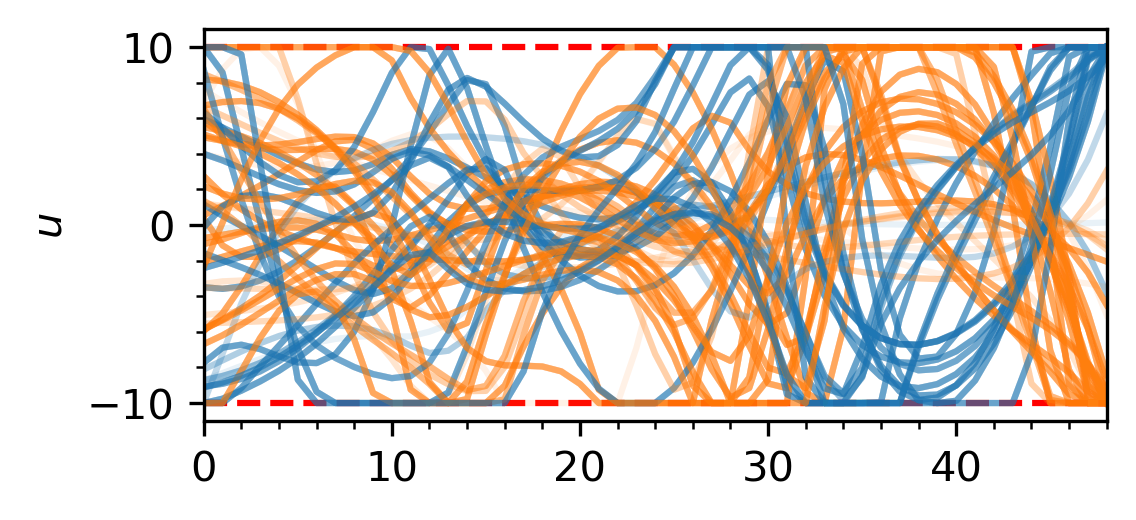

False

In [15]:
fig = plt.figure()
fig.set_size_inches(3.5,1.5)
fig.set_dpi(300)
plt.ylabel(r'$u$')
for i in range(control_trajectories.shape[0]):
    plt.plot(control_trajectories[i,:,:2], alpha=0.1, color=colors[i])
plt.hlines(-10,0,demos_full.shape[1]-2,'r','--')
plt.hlines(10,0,demos_full.shape[1]-2,'r','--')
plt.xlim(0, demos_full.shape[1]-2)
plt.minorticks_on()
plt.tight_layout()
fig.subplots_adjust(left=0.13, bottom=0.12, right=.99, top=0.99) # for 3.5 x 1.5
plt.show()
plot_to_pdf and fig.savefig('plot/cartpole_labelled_control_trajectories.pdf')

0 (172, 49, 1)
1 (243, 49, 1)


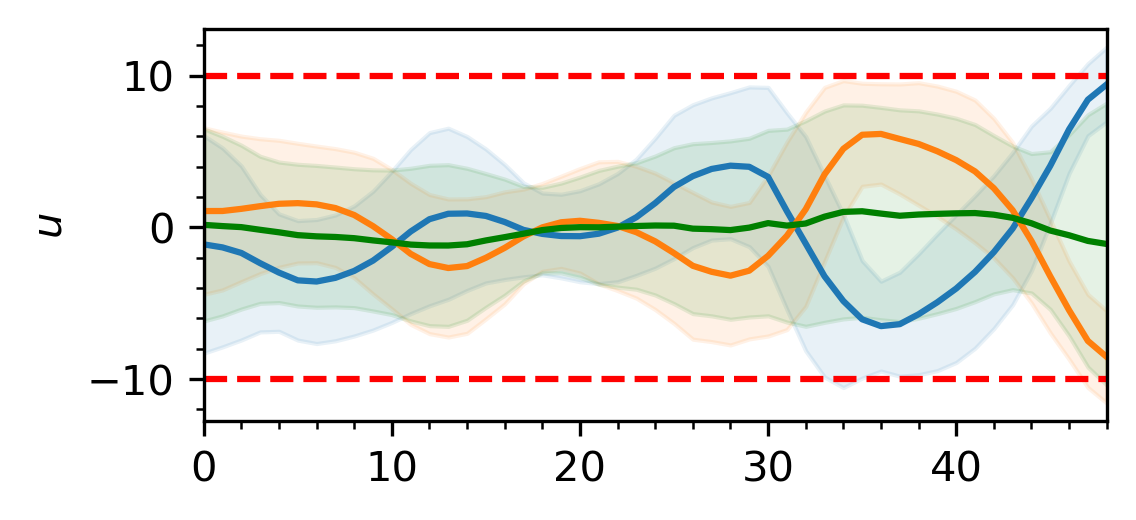

False

In [16]:
control_trajectory_modes = []
for i in range(num_classes):
    control_trajectory_modes.append(control_trajectories[np.where(labels==i)[0],:,:])
    print(i, control_trajectories[np.where(labels==i)[0],:,:].shape)

fig, ax = plt.subplots()
fig.set_size_inches(3.5,1.5)
fig.set_dpi(300)
plt.ylabel(r'$u$')
x = np.array([e for e in range(49)])
for i in range(num_classes):
    mean = np.mean(control_trajectory_modes[i], axis=0)
    std = np.std(control_trajectory_modes[i], axis=0)
    ax.plot(x, mean, alpha=1., color=clustering.class_color[i], label='Class ' + str(i) + ' Mean')
    mean_low = (mean-std)[:,0]
    mean_high = (mean+std)[:,0]
    ax.fill_between(x, mean_low, mean_high, alpha=0.1, color=clustering.class_color[i])

ax.plot(np.mean(control_trajectories, axis=0), 'g', label='Dataset Mean')
ax.fill_between(x,
                (np.mean(control_trajectories, axis=0)-np.std(control_trajectories, axis=0))[:,0],
                (np.mean(control_trajectories, axis=0)+np.std(control_trajectories, axis=0))[:,0],
                alpha=0.1, color='g')

plt.hlines(-10,0,demos_full.shape[1]-2,'r','--')
plt.hlines(10,0,demos_full.shape[1]-2,'r','--')
plt.xlim(0, demos_full.shape[1]-2)
plt.minorticks_on()
plt.tight_layout()
fig.subplots_adjust(left=0.13, bottom=0.12, right=.99, top=0.99) # for 3.5 x 1.5
plt.show()
plot_to_pdf and fig.savefig('plot/cartpole_class_aware_mean.pdf')

## Joint Plot

In [17]:
color_map = {}
color_map['green']   = ( 41/255.,  89/255.,  57/255., 1.0) # green
color_map['brown']   = ( 67/255.,  53/255.,  32/255., 1.0) # brown
color_map['blue']    = ( 35/255., 104/255., 155/255., 1.0) # blue
color_map['purple']  = (114/255., 106/255., 149/255., 1.0) # purple
color_map['red']     = (236/255.,  70/255.,  70/255., 1.0) # red
color_map['orange'] = (226/255., 120/255.,   2/255., 1.0) # orange
color_map['black'] = (0.,0.,0.)

class_colors = [color_map['orange'], color_map['blue']]

In [18]:
color_to_new_color_map = {}
color_to_new_color_map['tab:orange'] = color_map['orange']
color_to_new_color_map['tab:blue'] = color_map['blue']

In [19]:
new_colors = [color_to_new_color_map[c] for c in colors]

0 (172, 49, 1)
1 (243, 49, 1)


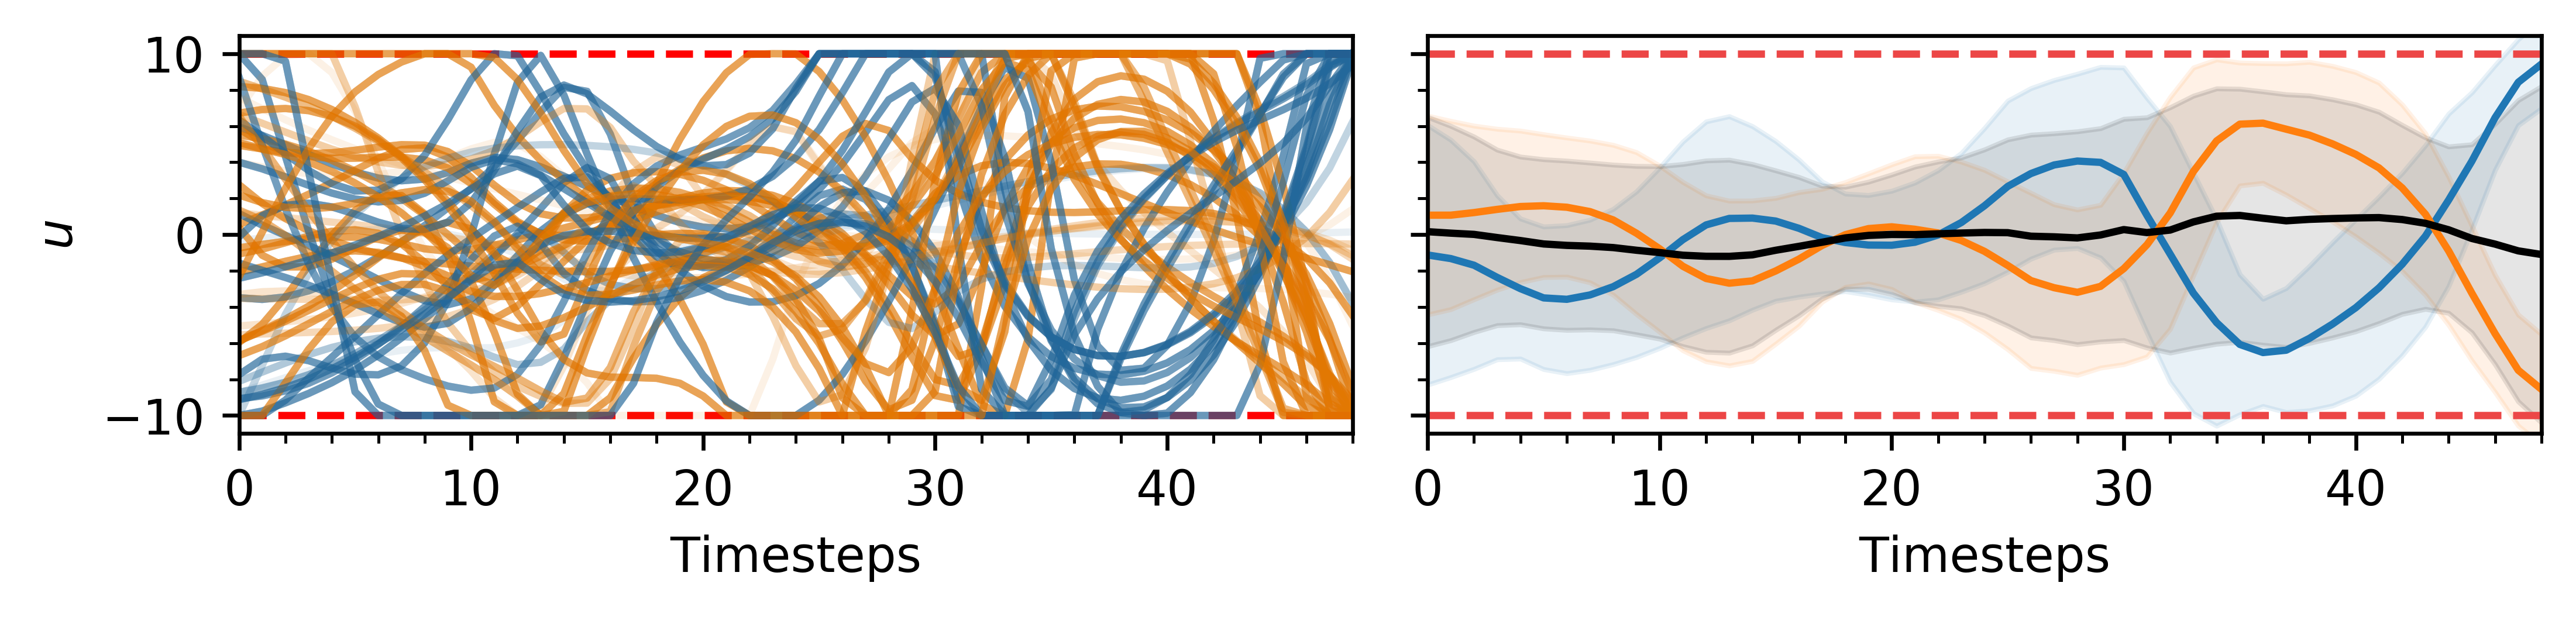

False

In [20]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(7,1.5)
fig.set_dpi(600)

plt.subplot(1,2,1)

plt.ylabel(r'$u$')
for i in range(control_trajectories.shape[0]):
    plt.plot(control_trajectories[i,:,:2], alpha=0.1, color=new_colors[i])
plt.hlines(-10,0,demos_full.shape[1]-2,'r','--')
plt.hlines(10,0,demos_full.shape[1]-2,'r','--')
plt.xlim(0, demos_full.shape[1]-2)
plt.ylim(-11, 11)
plt.minorticks_on()
plt.xlabel('Timesteps')

plt.subplot(1,2,2)

control_trajectory_modes = []
for i in range(num_classes):
    control_trajectory_modes.append(control_trajectories[np.where(labels==i)[0],:,:])
    print(i, control_trajectories[np.where(labels==i)[0],:,:].shape)

x = np.array([e for e in range(49)])
for i in range(num_classes):
    mean = np.mean(control_trajectory_modes[i], axis=0)
    std = np.std(control_trajectory_modes[i], axis=0)
    plt.plot(x, mean, alpha=1., color=clustering.class_color[i], label='Class ' + str(i) + ' Mean')
    mean_low = (mean-std)[:,0]
    mean_high = (mean+std)[:,0]
    plt.fill_between(x, mean_low, mean_high, alpha=0.1, color=clustering.class_color[i])
plt.plot(np.mean(control_trajectories, axis=0), color=color_map['black'], label='Dataset Mean')
plt.fill_between(x,
                (np.mean(control_trajectories, axis=0)-np.std(control_trajectories, axis=0))[:,0],
                (np.mean(control_trajectories, axis=0)+np.std(control_trajectories, axis=0))[:,0],
                alpha=0.1, color=color_map['black'])

plt.hlines(-10,0,demos_full.shape[1]-2,color_map['red'],'--')
plt.hlines(10,0,demos_full.shape[1]-2,color_map['red'],'--')
plt.xlim(0, demos_full.shape[1]-2)
ytick_locs, ytick_labels = plt.yticks()
for i in range(len(ytick_labels)):
    ytick_labels[i].set_text('')
plt.yticks(ytick_locs, ytick_labels)
plt.ylim(-11, 11)
plt.minorticks_on()
plt.xlabel('Timesteps')

plt.tight_layout()
fig.subplots_adjust(left=0.061, bottom=0.234, right=.998, top=0.99) # for 3.5 x 1.5

plt.show()
plot_to_pdf and fig.savefig('plot/cartpole_class_labels_and_aware_mean.pdf')
plot_to_pdf and fig.savefig('plot/cartpole_class_labels_and_aware_mean.png')

0 (172, 49, 1)
1 (243, 49, 1)


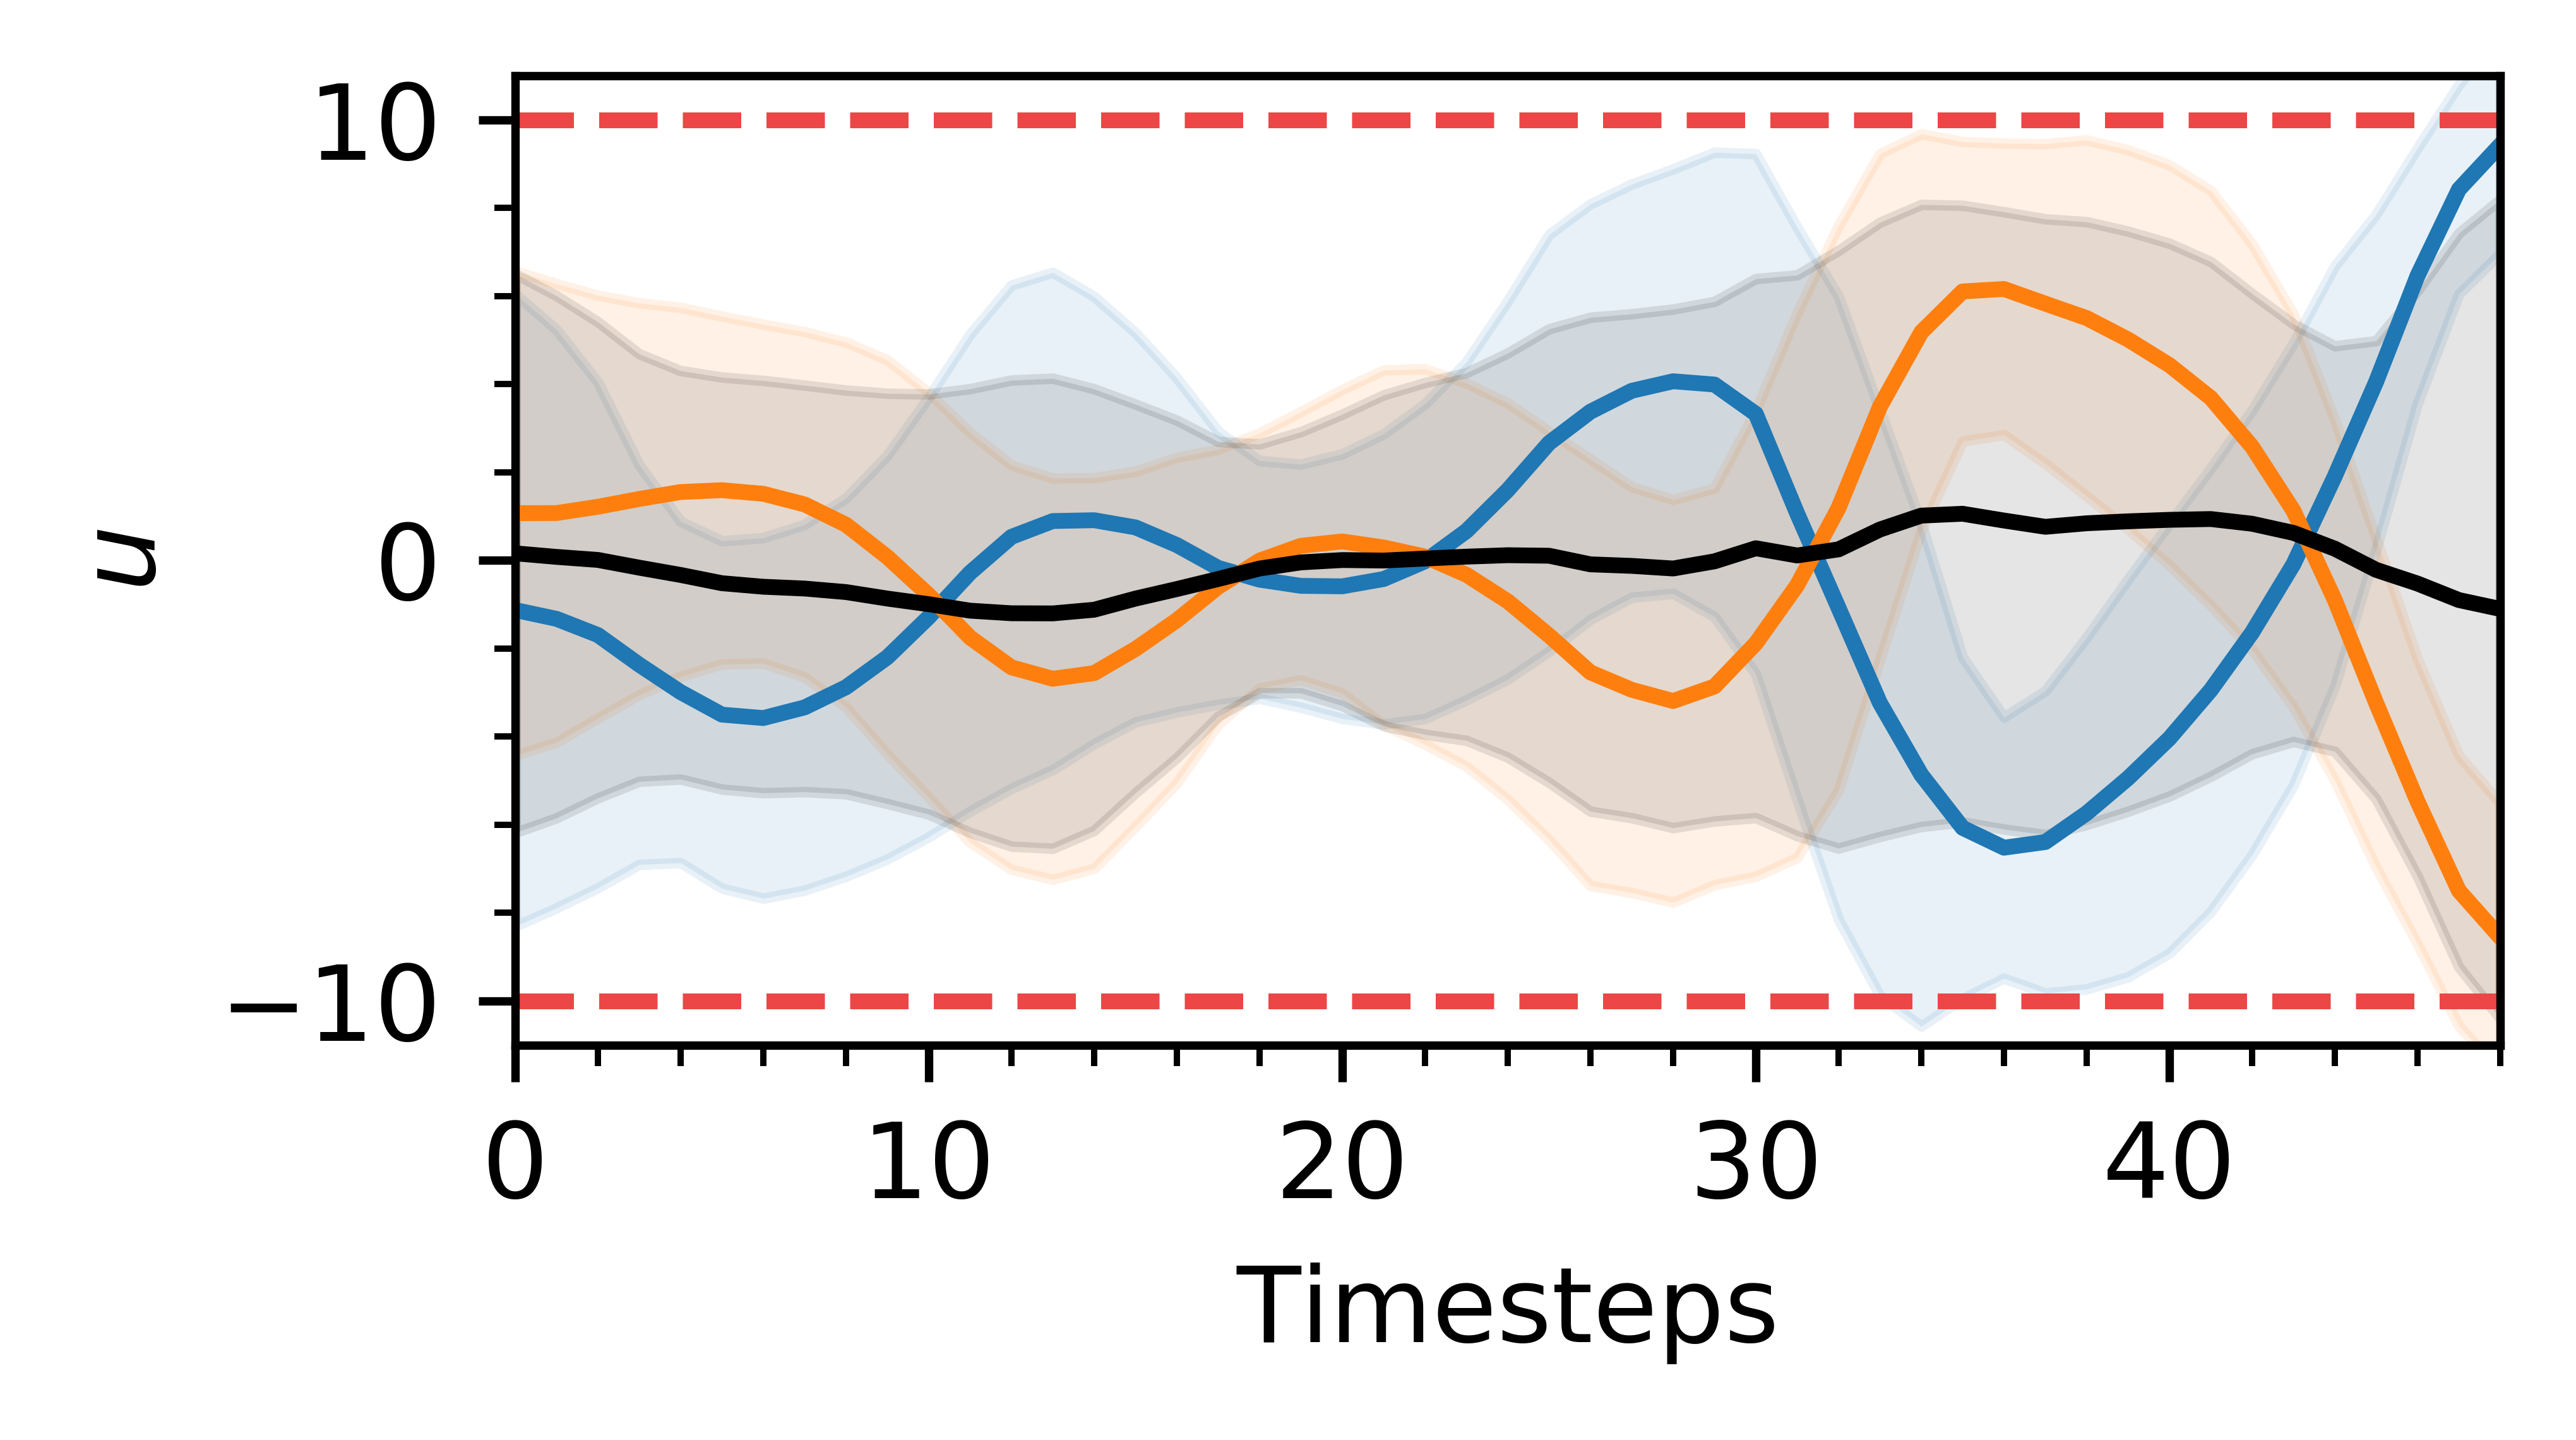

False

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(3.5,2)
fig.set_dpi(1200)

plt.ylabel(r'$u$')

control_trajectory_modes = []
for i in range(num_classes):
    control_trajectory_modes.append(control_trajectories[np.where(labels==i)[0],:,:])
    print(i, control_trajectories[np.where(labels==i)[0],:,:].shape)

x = np.array([e for e in range(49)])
for i in range(num_classes):
    mean = np.mean(control_trajectory_modes[i], axis=0)
    std = np.std(control_trajectory_modes[i], axis=0)
    plt.plot(x, mean, alpha=1., color=clustering.class_color[i], label='Class ' + str(i) + ' Mean')
    mean_low = (mean-std)[:,0]
    mean_high = (mean+std)[:,0]
    plt.fill_between(x, mean_low, mean_high, alpha=0.1, color=clustering.class_color[i])
plt.plot(np.mean(control_trajectories, axis=0), color=color_map['black'], label='Dataset Mean')
plt.fill_between(x,
                (np.mean(control_trajectories, axis=0)-np.std(control_trajectories, axis=0))[:,0],
                (np.mean(control_trajectories, axis=0)+np.std(control_trajectories, axis=0))[:,0],
                alpha=0.1, color=color_map['black'])

plt.hlines(-10,0,demos_full.shape[1]-2,color_map['red'],'--')
plt.hlines(10,0,demos_full.shape[1]-2,color_map['red'],'--')
plt.xlim(0, demos_full.shape[1]-2)
plt.ylim(-11, 11)
plt.minorticks_on()
plt.xlabel('Timesteps')

plt.tight_layout()

plt.show()
plot_to_pdf and fig.savefig('plot/cartpole_class_aware_mean_single.pdf')
plot_to_pdf and fig.savefig('plot/cartpole_class_aware_mean_single.png')

---

In [22]:
# Save
np.savez('clustering_result', result=result, D=D, labels=labels, state_trajectories=state_trajectories, control_trajectories=control_trajectories)